# SD701
## Lab on real-world graph analysis

The objective of this lab is to get a feeling of real-world graphs. For information on the `scikit-network` library, [the documentation is handy](https://scikit-network.readthedocs.io/).

## Import

In [1]:
import numpy as np

In [2]:
import networkx as nx

In [3]:
import matplotlib.pyplot as plt
from itertools import groupby

In [4]:
import sknetwork as skn

In [5]:
# Util function to plot the inverse cumulative distribution
def ccdf(values):
    x = []
    y = []
    values = sorted(values)

    # First make dist
    dist = [(key, len(list(group))) for key, group in groupby(values)]

    # Then compute inverse cumulative
    # inverse cumulative是P(x > valeur)
    total = 1.0
    for (val, count) in dist:
        x.append(val)
        y.append(total)
        total -= count/len(values)
    return x, y

# Util function to return the distribution of values
def dist(values):
    values = sorted(values)

    # First make dist
    dist = [(key, len(list(group))) for key, group in groupby(values)]
    
    return [x[0] for x in dist], [x[1] for x in dist]

## Load data

We will work on 2 graphs induced by the [Vital articles of Wikipedia](https://en.wikipedia.org/wiki/Wikipedia:Vital_articles/Level/4), a selection of about 10,000 articles of the English Wikipedia:
* the directed graph of hyperlinks between these articles,
* the bipartite graph between articles and (stemmed) words used in their summary.

In [6]:
data = skn.data.load_netset('wikivitals')
data.keys()

Parsing files...
Done.


dict_keys(['adjacency', 'biadjacency', 'labels', 'labels_hierarchy', 'meta', 'names', 'names_col', 'names_labels', 'names_labels_hierarchy'])

In [7]:
# graph of links
adjacency = data.adjacency

In [8]:
# graph of words
biadjacency = data.biadjacency

In [9]:
# article names
names = data.names

In [10]:
# article categories
categories = data.names_labels
categories

array(['Arts', 'Biological and health sciences', 'Everyday life',
       'Geography', 'History', 'Mathematics', 'People',
       'Philosophy and religion', 'Physical sciences',
       'Society and social sciences', 'Technology'], dtype='<U30')

In [11]:
# words
words = data.names_col
words

array(['Alexis', 'Cairo', 'subordinate', ..., 'parody', 'martyrdom',
       'Wyler'], dtype='<U26')

In [12]:
node_index = {name:i for i, name in enumerate(names)}

In [13]:
n_articles, n_words = biadjacency.shape

In [14]:
labels = data.labels

### Basic statistics

* Compute the number of nodes and edges for each of the two Wikivitals graph

The number of nodes is nothing more than the number of rows / columns in the matrix. For the articles, the matrix is square (because the graph is unipartite), but the words graph is bipartite : there are _words_ linked to _articles_. For the edges, remember that each edge corresponds to a non zero value in the matrix. As such, `matrix.nnz` contains exactly the number of edges.

In [15]:
print(f"There are {adjacency.shape[0]} nodes in the articles graph.")

There are 10011 nodes in the articles graph.


In [16]:
num_articles = biadjacency.shape[0]
num_words = biadjacency.shape[1]
print(f"There are {num_articles} articles in the words graph, and {num_words} words, so that's a total of {num_articles+num_words} nodes.")

There are 10011 articles in the words graph, and 37845 words, so that's a total of 47856 nodes.


In [17]:
print(f"There are {adjacency.nnz} edges in the article graph.")
print(f"There are {biadjacency.nnz} edges in the words graph.")

There are 824999 edges in the article graph.
There are 1363301 edges in the words graph.


### Degrees

* What are the minimum degree? The maximum one?
* Compute (and plot) the degree distribution of the Wiki graph, in log-log scale

We know that in the adjacency matrix, the presence of an edge between nodes i and j corresponds to a 1 in the matrix at coordinates (i,j). So, if we count the number of $1$'s in row i, we obtain the number of neighbours of node i (i.e. its degree).
To do this efficiently for all nodes, we compute the matrix product between `adjacency` and an adequately sized vector of $1$'s.

In [18]:
degrees = np.array(adjacency.dot(np.ones(adjacency.shape[0])))

In [19]:
min(degrees), max(degrees), np.mean(degrees)

(0.0, 680.0, 82.40924982519229)

Let us now look at the degree distribution. We use the helper functions `dist` and `ccdf` (for **C**umulative **C**onverse **D**istribution **F**unction)

Text(0, 0.5, 'Number of words having degree = k')

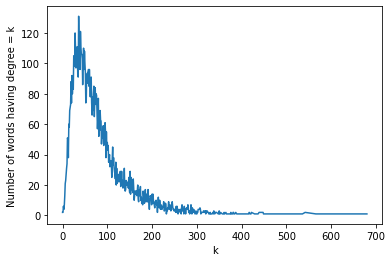

In [20]:
import matplotlib.pyplot as plt

degree_dist_x, degree_dist_y = dist(degrees)

plt.plot(degree_dist_x, degree_dist_y)
plt.xlabel("k")
plt.ylabel("Number of words having degree = k")

This distributions are interesting, but somewhat "noisy", which can make them hard to read. It is sometimes useful to look intead at the Inverse Cumulative Distribution, that is usually much smoother.

PS:CCDF(P(X > k))

Text(0, 0.5, 'Number of words having degree >= k')

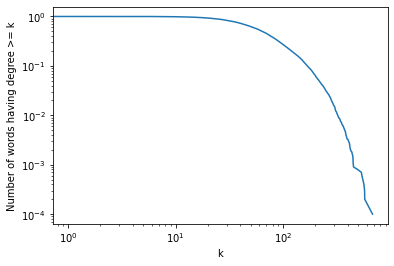

In [21]:
degree_ccdf_x, degree_ccdf_y = ccdf(degrees)

plt.loglog(degree_ccdf_x, degree_ccdf_y)
plt.xlabel("k")
plt.ylabel("Number of words having degree >= k")

Let us do the same for the biadjacency matrix. We use the same "trick", however notice that there are two types of nodes (the matrix is not square anymore), so we have to separate the degrees of the articles and the words.

In [22]:
biadj_articles_degrees = np.array(biadjacency.dot(np.ones(biadjacency.shape[1])))
biadj_words_degrees = np.array(biadjacency.T.dot(np.ones(biadjacency.shape[0])))

#biadj_articles_degrees = np.array(biadjacency.T.dot(np.ones(biadjacency.shape[0])))
#biadj_words_degrees = np.array(biadjacency.dot(np.ones(biadjacency.shape[1])))

In [23]:
print("Articles:", min(biadj_articles_degrees), max(biadj_articles_degrees), np.mean(biadj_articles_degrees))
print("Words:", min(biadj_words_degrees), max(biadj_words_degrees), np.mean(biadj_words_degrees))

Articles: 14.0 1114.0 265.69613425232245
Words: 2.0 206697.0 70.28363059849386


Text(0, 0.5, 'Number of articles having degree = k')

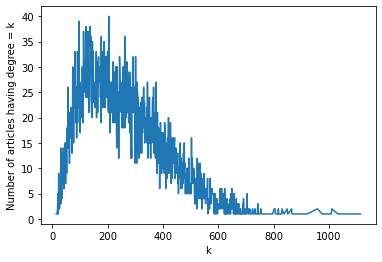

In [24]:
degree_articles_dist_x, degree_articles_dist_y = dist(biadj_articles_degrees)
degree_words_dist_x, degree_words_dist_y = dist(biadj_words_degrees)

plt.plot(degree_articles_dist_x, degree_articles_dist_y)
plt.xlabel("k")
plt.ylabel("Number of articles having degree = k")

Text(0, 0.5, 'Number of words having degree = k')

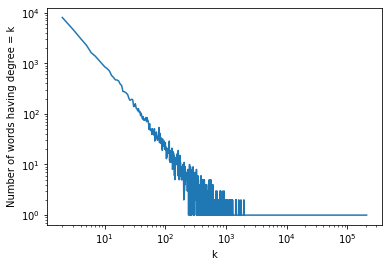

In [25]:
plt.loglog(degree_words_dist_x, degree_words_dist_y)
plt.xlabel("k")
plt.ylabel("Number of words having degree = k")
#power law长尾分布

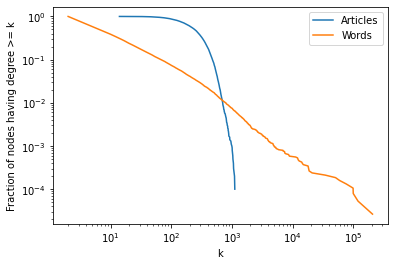

In [26]:
degree_articles_ccdf_x, degree_articles_ccdf_y = ccdf(biadj_articles_degrees)
degree_words_ccdf_x, degree_words_ccdf_y = ccdf(biadj_words_degrees)


plt.loglog(degree_articles_ccdf_x, degree_articles_ccdf_y, label="Articles")
plt.loglog(degree_words_ccdf_x, degree_words_ccdf_y, label="Words")
plt.xlabel("k")
plt.ylabel("Fraction of nodes having degree >= k")
plt.legend()

### Global density

* Compute the density of the Wikivitals graphs *(careful, one of the graphs is bipartite)*

Remember that the density for a graph $G=(V,E)$ is $\delta(G) = \frac{2|E|}{|V|(|V|-1)}$. This corresponds to the number of edges divided to the number of possible edges with $|V|$ nodes. In the bipartite case, not all nodes can be linked together (this is what bipartite means: edges involve one node of each "category"). So, given a bipartite graph $B=(\top, \bot, E)$, the density value is $\delta(B) = \frac{2|E|}{|\top||\bot|}$.

In [27]:
density_adj = adjacency.nnz / (adjacency.shape[0] * (adjacency.shape[0]-1))
density_biadj = biadjacency.nnz / (biadjacency.shape[0] * biadjacency.shape[1])

density_adj, density_biadj
#为什么不乘以二？？？？

(0.008232692290229, 0.0035983697098207167)

Notice that this density is very low, which is a typical property of real world graphs, as we saw during the lecture.

## Traversal

* Code a Breadth-First Search traversal
* Adapt your code to a Depth-First Search traversal
* Apply it to the two graphs

In [28]:
def bfs(graph, source=None):
    """
        Given a graph, returns a list of nodes corresponding to a
        Breadth-First search traversal. If source is None, pick a node randomly.
    """
    from collections import deque # Let us use a queue structure
    
    result = [] # We'll store the result here
    seen_nodes = set() # To keep track of nodes we have already seen
    nodes_to_consider = deque()
    
    if source is None:
        source = 0
    nodes_to_consider.append(source)
    
    while len(nodes_to_consider) > 0:
        # Let's take the first node, add it to the result and to the list of seen nodes
        curr_node = nodes_to_consider.popleft()
        result.append(curr_node)
        seen_nodes.add(curr_node)
        
        # Now, let's add each neighbour of curr_node that we have not already seen to nodes_to_consider.
        # We can get the neighbours efficiently thanks to the CSR matrix format and its "indptr" array.
        # Check the lecture slides and video again if the next line looks completely arcane to you! :) 
        for neighbour in graph.indices[graph.indptr[curr_node]:graph.indptr[curr_node+1]]:
            if neighbour not in seen_nodes:
                nodes_to_consider.append(neighbour)

    return result

res = bfs(adjacency)
len(res)
#？？为什么只找不连通的，node还会变多？

1687716

Notice here that the number of nodes at the end of the BFS is not the same as the number of nodes in the graph. This is because we only enumerated one connected component, and then stopped. Below is a more general code, that will restart until there are truly no more nodes to consider.

In [29]:
def general_bfs(graph, source=None):
    """
        Given a graph, returns a list of nodes corresponding to a
        Breadth-First search traversal. If source is None, pick a node randomly.
    """
    from collections import deque # Let us use a queue structure
    
    result = [] # We'll store the result here
    seen_nodes = set() # To keep track of nodes we have already seen
    nodes_to_consider = deque()
    
    all_nodes = [ i for i in range(len(graph.indptr) - 1)] # We know that graph.indptr has size |V|+1
    
    if source is None:
        source = 0
    nodes_to_consider.append(source)
    
    while len(nodes_to_consider) > 0 or len(seen_nodes) != len(all_nodes):
        # Let's take the first node, add it to the result and to the list of seen nodes
        if len(nodes_to_consider) > 0:
            curr_node = nodes_to_consider.popleft()
        else:
            # We reached the end of a connected component, let us pick a new source
            curr_node = [ i for i in all_nodes if i not in seen_nodes ][0]
        if curr_node not in seen_nodes:
            result.append(curr_node)
        seen_nodes.add(curr_node)
        
        # Now, let's add each neighbour of curr_node that we have not already seen to nodes_to_consider.
        # We can get the neighbours efficiently thanks to the CSR matrix format and its "indptr" array.
        # Check the lecture slides and video again if the next line looks completely arcane to you! :) 
        for neighbour in graph.indices[graph.indptr[curr_node]:graph.indptr[curr_node+1]]:
            if neighbour not in seen_nodes:
                nodes_to_consider.append(neighbour)

    return result

res = general_bfs(adjacency)
len(res)

10011

## PageRank

The [PageRank](https://en.wikipedia.org/wiki/PageRank) algorithm can be used to recommend nodes (here articles) close to some target.

## To do 

Using the 2 graphs (links, words):
* List the 10 articles the closest to some target of your choice (e.g., Vincent van Gogh).
* For the word graphs, list the 10 closest words of this target.
* Do the same with multiple targets.

In [53]:
pr = skn.ranking.PageRank()

In [56]:
#target = node_index['Frida Kahlo']
target = node_index['Germany']

In [57]:
pr.fit(adjacency, seeds={target:1})

PageRank(damping_factor=0.85, solver='piteration', n_iter=10, tol=1e-06)

Now that we have trained our PageRank, we want the index of the pages that have the highest PageRank score. Just sorting the `pr.scores_` array would not be good enough (we would have the value of the highest scores, but lose the pages indices). Instead, we use `np.argsort`, that returns an array of indices sorted corresponding to their value in the original array. We then keep the last 10 values (the highest ones).

In [58]:
high_pr_names = [ names[x] for x in np.argsort(pr.scores_)[-10:] ]
high_pr_names

['Italy',
 'Russia',
 'India',
 'World War I',
 'Geographic coordinate system',
 'United Kingdom',
 'France',
 'World War II',
 'United States',
 'Germany']

We cannot straightforwardly do the same for the words graphs, as it is bipartite (and so the adjacency matric is not square, a key requirement of PageRank). Instead, we can modify the matrix into the "mirror graph" that we saw during the lecture, i.e. for a graph with adjacency matrix $A$, its mirror graph $B$ is:

$$
B = \begin{bmatrix}
0 & A \\
A^T & 0
\end{bmatrix}
$$

where $A^T$ is the transpose of $A$. This works because adding $0$s does not change the links of the graph. Thankfully, we do not have to implement this transformation ourselves, as `scikit-network` gives us a `BiPageRank` object that does exactly this. However, we need a slight adaptation to the seeds map, to separate seeds on the two types of nodes in the bipartite graph.

In [63]:
#bi_pr = skn.ranking.BiPageRank()
bi_pr = skn.ranking.PageRank()
target = node_index['Frida Kahlo']
bi_pr.fit(biadjacency, seeds_row={target:1})
high_bipr_names = [ names[x] for x in np.argsort(bi_pr.scores_)[-10:] ]
high_bipr_names

['Marius Petipa',
 'Spanish conquest of the Aztec Empire',
 'Marilyn Monroe',
 'Antonio López de Santa Anna',
 'Feminism',
 'Mexican Revolution',
 'Carmen',
 'Mexican–American War',
 'Diego Rivera',
 'Frida Kahlo']

Let us just do the same again with another page, just to see how the results are different thanks to personalized PageRank. :) The full list of pages in the WikiVitals graph is here: [https://en.wikipedia.org/wiki/Wikipedia:Vital_articles/Level/4](https://en.wikipedia.org/wiki/Wikipedia:Vital_articles/Level/4)

In [64]:
page_name = "Emmy Noether" 
target = node_index[page_name]
pr.fit(adjacency, seeds={target:1})
bi_pr.fit(biadjacency, seeds_row={target:1})
high_pr_names = [ names[x] for x in np.argsort(pr.scores_)[-10:] ]
high_bipr_names = [ names[x] for x in np.argsort(bi_pr.scores_)[-10:] ]

high_pr_names, high_bipr_names

(['Group theory',
  'Vector space',
  'Prime number',
  'Algebraic geometry',
  'Physics',
  'Integer',
  'Field (mathematics)',
  'Set (mathematics)',
  'Real number',
  'Emmy Noether'],
 ['Conservation of energy',
  'Algebraic geometry',
  'Representation theory',
  'Max Born',
  'Katharine Hepburn',
  'Compact space',
  'Ring (mathematics)',
  'Ring theory',
  'Nuremberg',
  'Emmy Noether'])

## Community detection

## To do

For the 2 graphs:
* Cluster the graph.
* Display the 5 most important nodes of each cluster (in terms of PageRank).
* Evaluate the quality of the clustering using the categories as ground-truth.

In [65]:
from sklearn.metrics import adjusted_rand_score as ari

In [66]:
louvain = skn.clustering.Louvain()

In [84]:
louvain.fit(adjacency)
#louvain.adjacency
louvain

Louvain(resolution=1, modularity='dugue', tol_aggregation=0.001, n_aggregations=-1, shuffle_nodes=False, sort_clusters=True, return_membership=True, return_aggregate=True)

Fortunately, the code for clustering the graph is already written for us. A bit of exploration shows us that the clustering results are held into the `labels_` array (the integer at index $i$ is the cluster of node $i$). Let us run a non-personalized pagerank on the whole graph, then filter pages by cluster.

In [71]:
pr = skn.ranking.PageRank()
pr.fit(adjacency)

PageRank(damping_factor=0.85, solver='piteration', n_iter=10, tol=1e-06)

In [74]:
pr_scores_indices = np.argsort(pr.scores_)

nb_clusters = max(louvain.labels_) # The maximum value is the number of clusters

# Let us iterate on each cluster, keep only the nodes from said cluster, and sorte them to keep only the maximum 5 scores
for i in range(nb_clusters):
    current_cluster = []
    for u in pr_scores_indices:
        if louvain.labels_[u] == i:
            # Keep onl the current cluster
            current_cluster.append(u)
    # The scores are already sorted, let's keep keep the last five elements, and use the "names" array to display the page names rather than the indices. :) 
    print(f"Cluster {i}")
    print([names[x] for x in current_cluster[-5:]])

louvain.labels_[node_index[page_name]]

Cluster 0
['Oxford English Dictionary', 'Bacteria', 'Protein', 'Animal', 'Taxonomy (biology)']
Cluster 1
['Physics', 'Nature (journal)', 'Mathematics', 'Earth', 'Oxygen']
Cluster 2
['China', 'India', 'France', 'Geographic coordinate system', 'United States']
Cluster 3
['Islam', 'Middle Ages', 'Christianity', 'Greek language', 'Latin']
Cluster 4
['North America', 'British Empire', 'Russian Empire', 'Ottoman Empire', 'Europe']
Cluster 5
['Time (magazine)', 'BBC', 'Encyclopædia Britannica', 'The New York Times', 'Bibliothèque nationale de France']


1

Finally, we know that the categories of each page are stored in the `labels` array (see the beginning of this notebook). We want to evaluate to which extent the clusters correspond to the categories of the Wikivitals dataset. We here use the [Adjusted Rand Index](https://en.wikipedia.org/wiki/Rand_index#Adjusted_Rand_index), which compares the clustering to a ground through while correcting for sheer luck. It is a score between $0$ and $1$.

In [69]:
ari(labels, louvain.labels_)

0.3018954851357631

One last point, you might wonder what "$0.30$" ARI means in this context; is it good? Is it meh? This is a legitimate question, that has no absolute answer. Some elements of answer: 

- One could compare Louvain to other algorithms, and decide that Louvain is "good" if the ARI is better than with other methods. This could be summed up as "all clustering methods are bad, Louvain is just _less bad_".
- Another possibility is to explore the mismatches between the ground truth and the labels, for example via a confusion matrix, and see if the errors are acceptable, or explainable.
